In [67]:
import sys
import os
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import IPython.display as display


# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
import imp
imp.reload(visualize)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from fashion_cnn import coco_main

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "model")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco_0067.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    print('here')
    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
#SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

In [27]:
dataset = coco_main.FashionDataset()
json_file_dir = "C:/tensor_code/fashion/dataset/deepfashion2/train/coco_train_1.json"  # TODO: enter value here
image_dir="C:/tensor_code/fashion/dataset/deepfashion2/train/1"
dataset.load_coco(json_file_dir=json_file_dir,image_dir=image_dir)

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=19.15s)
creating index...
index created!
Image Count: 19196
Class Count: 14
  0. BG                                                
  1. short_sleeved_shirt                               
  2. long_sleeved_shirt                                
  3. short_sleeved_outwear                             
  4. long_sleeved_outwear                              
  5. vest                                              
  6. sling                                             
  7. shorts                                            
  8. trousers                                          
  9. skirt                                             
 10. short_sleeved_dress                               
 11. long_sleeved_dress                                
 12. vest_dress                                        
 13. sling_dress                                       


In [28]:
config = coco_main.FashionConfig()

class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                26
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [29]:
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [30]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [31]:
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [32]:
print("Loading weights ", COCO_MODEL_PATH)
model.load_weights(COCO_MODEL_PATH, by_name=True)

Loading weights  C:\tensor_code\fashion\model\mask_rcnn_coco_0067.h5


image ID: coco.30321 (16749) http://cocodataset.org/#explore?id=30321
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (2,)                  min:    1.00000  max:    9.00000  int32
gt_bbox                  shape: (2, 4)                min:   31.00000  max:  716.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  bool


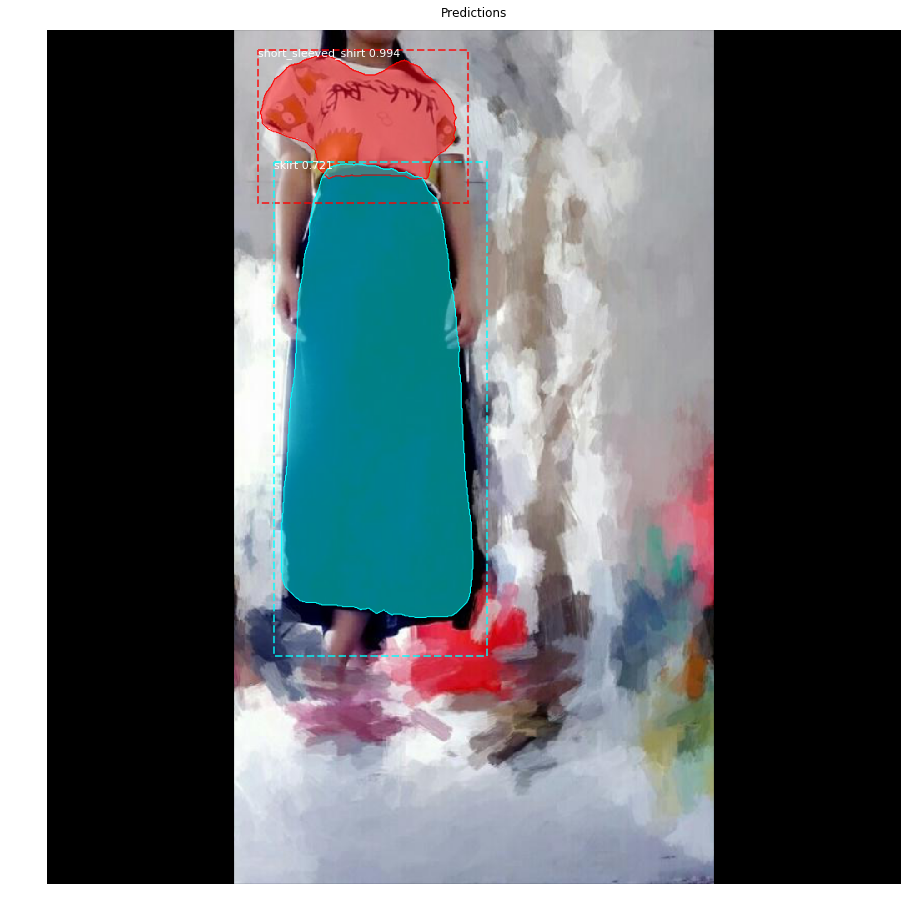

In [153]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

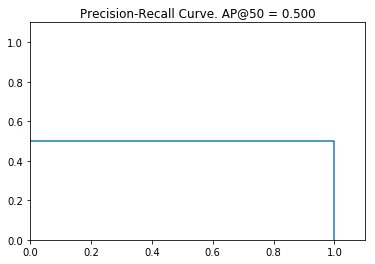

In [35]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

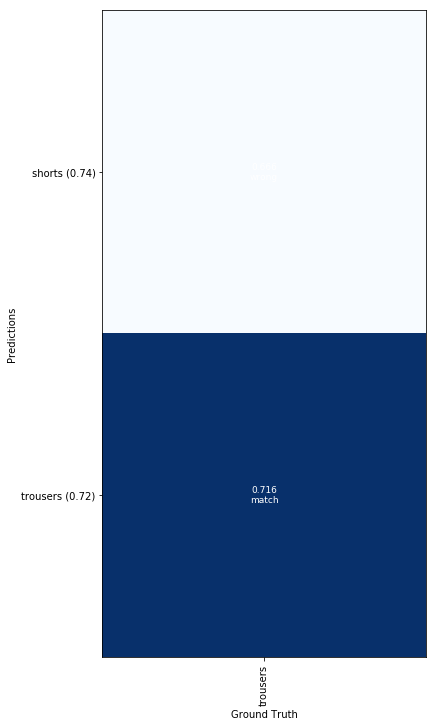

In [36]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

## Check dolor distribution

In [57]:
import skimage

def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]
    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # We're treating all instances as one, so collapse the mask into one layer
    mask = (np.sum(mask, -1, keepdims=True) >= 1)
    # Copy color pixels from the original color image where mask is set
    if mask.shape[0] > 0:
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray
    return splash

In [142]:
def get_colort_values(image,mask):
    '''return r,g,b values of given clothes'''

    assert len(mask.shape)==2
    assert image.shape[-1]==3
    
    r_values=image[:,:,0][mask]
    g_values=image[:,:,1][mask]
    b_values=image[:,:,2][mask]
    
    return r_values,g_values,b_values

In [170]:
mask=results[0]['masks'][:,:,1]
color_values=get_colort_values(image,mask)

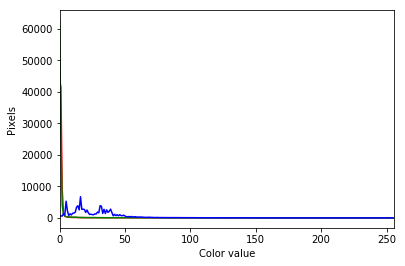

In [171]:
colors = ("r", "g", "b")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.xlim([0, 256])
for idx,color in enumerate(zip(channel_ids, colors)):
    histogram, bin_edges = np.histogram(
        color_values[idx], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=color[1])

plt.xlabel("Color value")
plt.ylabel("Pixels")

plt.show()

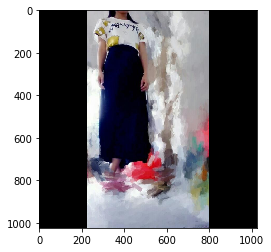

In [172]:
plt.imshow(image)

## Change color

In [173]:
r=15.0
g=76.0
b=129.0

### Random Noise

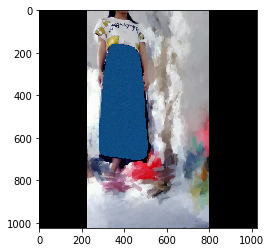

In [277]:
change_color=image.copy()
rgb=np.array([r,g,b])
def make_noise(rgb,masking_values):
    '''rgb : array of rgb(float),maskiv_values:(N pixels,3)'''
    change_shape=masking_values.shape
    rgb_std=np.sqrt(abs(np.std(masking_values,axis=0)))
    noise=np.random.normal(rgb,rgb_std,size=change_shape)
    noise[noise<=0]=0
    return noise

noise=make_noise(rgb,image[mask])
change_color[mask]=noise
plt.imshow(change_color)

### Shifting

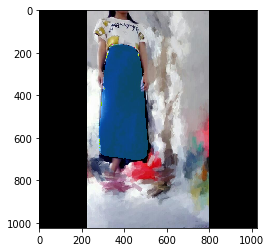

In [285]:
change_color=image.copy()
def shift_mu(rgb,masking_values):
    
    original_rgb_mean=np.mean(masking_values,axis=0)
   
    shift=rgb-original_rgb_mean
    
    shifted=masking_values+shift
    shifted[shifted<=0]=0
    
    return shifted
    
mask_shifted=shift_mu(rgb,image[mask])
change_color[mask]=mask_shifted
plt.imshow(change_color)

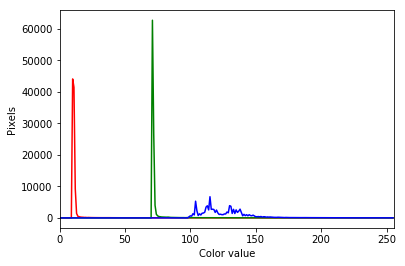

In [286]:
colors = ("r", "g", "b")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.xlim([0, 256])
for idx,color in enumerate(zip(channel_ids, colors)):
    histogram, bin_edges = np.histogram(
        mask_shifted[:,idx], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=color[1])

plt.xlabel("Color value")
plt.ylabel("Pixels")

plt.show()

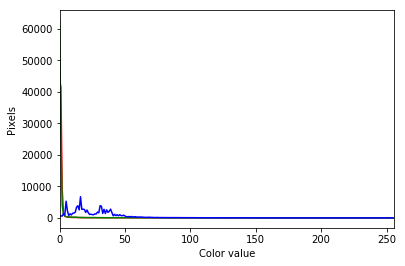

In [287]:
colors = ("r", "g", "b")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.xlim([0, 256])
for idx,color in enumerate(zip(channel_ids, colors)):
    histogram, bin_edges = np.histogram(
        image[mask][:,idx], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=color[1])

plt.xlabel("Color value")
plt.ylabel("Pixels")

plt.show()